# Exercise 3 – Interpretation von Modellen

### c) Welche Charakteristika eines weiblichen Krebses in `crabs.txt` finden männliche Krebs (sogenannte Satellites auf Englisch) anziehend? Schätzen Sie die Anzahl der männlichen Krebse in Test-Datensatz anhand der Charakteristika der weiblichen Krebse.

###### Einlesen des Datensatzes

In [14]:
# import packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt  # for parallel coordinates
#import pandas.plotting.scatter_matrix  # for scatter matrix
import sklearn.preprocessing  # for normalization
# load dataset
data = pd.read_csv('./data/crabs.txt', sep="\s+", header=None)
data.columns = ["ID", "Color", "Spine", "Width", "Weight", "Sallite"]

###### Vertrautmachen mit den Daten

In [15]:
data.count()

ID         173
Color      173
Spine      173
Width      173
Weight     173
Sallite    173
dtype: int64

Die Daten umfassen 173 weibliche Pfeilschwanzkrebse. Zu jedem Krebs wird die Helligkeit (color), der Zustand des Rückens (spine), die Breite des Panzers (width), das Gewicht (weight) sowie die Anzahl der männlichen Anhänger (sallite) angegeben.

In [16]:
data = data.sort_values("Sallite", ascending=False)
data.head()

,ID,Color,Spine,Width,Weight,Sallite
100,101,2,3,28.3,3.00,15
47,48,2,1,26.0,2.30,14
158,159,4,3,29.3,3.23,12
132,133,2,3,28.2,3.05,11
60,61,2,3,29.0,3.20,10


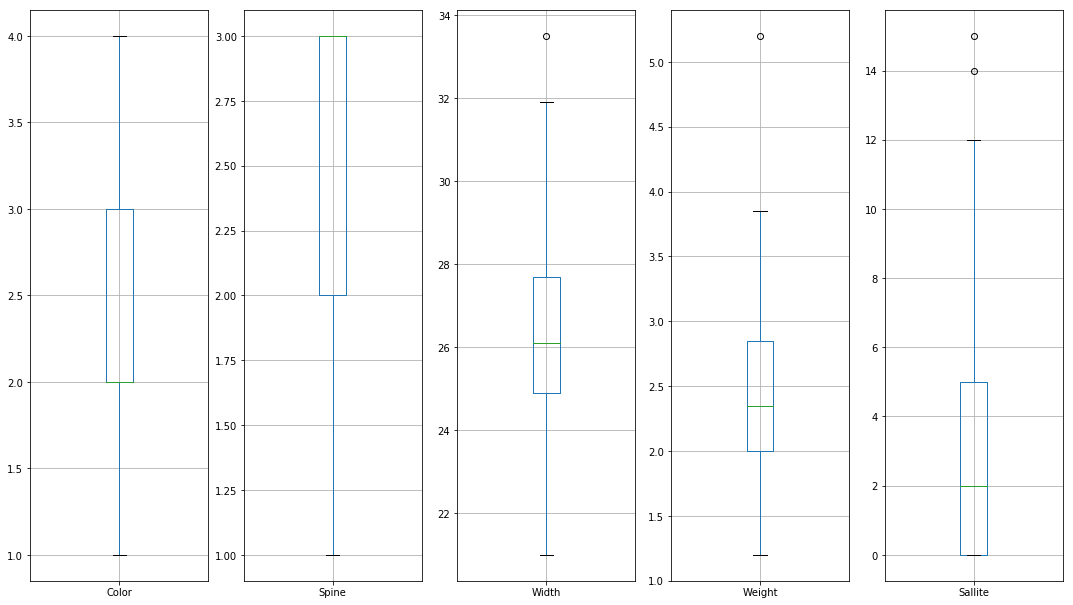

In [13]:
fig, axes = plt.subplots(1,5)
data.boxplot("Color", ax=axes.flatten()[0])
data.boxplot("Spine", ax=axes.flatten()[1])
data.boxplot("Width", ax=axes.flatten()[2])
data.boxplot("Weight", ax=axes.flatten()[3])
data.boxplot("Sallite", ax=axes.flatten()[4])
fig.set_size_inches(18.5, 10.5)
plt.show()

Die Kraben mit den meisten männlichen Anhängern haben in der Regel eine Durchschnittliche Färbung, der Zustand des Rückens ist gut, der Panzer relativ breit und das Gewicht relativ durchschnittlich. Um einen besseren Überblick zu schaffen werden im Folgenden parallele Koordinaten und eine Scatter-Matrix dargestellt.

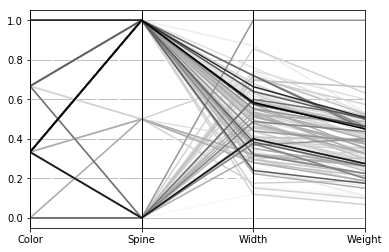

In [23]:
x = data.values
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaledData = pd.DataFrame(x_scaled)
scaledData.columns = ["ID", "Color", "Spine", "Width", "Weight", "Sallite"]
scaledData=scaledData.sort_values('Sallite')

ax = pd.plotting.parallel_coordinates(scaledData, 'Sallite', cols=["Color", "Spine", "Width", "Weight"], colormap='Greys')
ax.legend().remove()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002191FA35A58>,
      dtype=object)

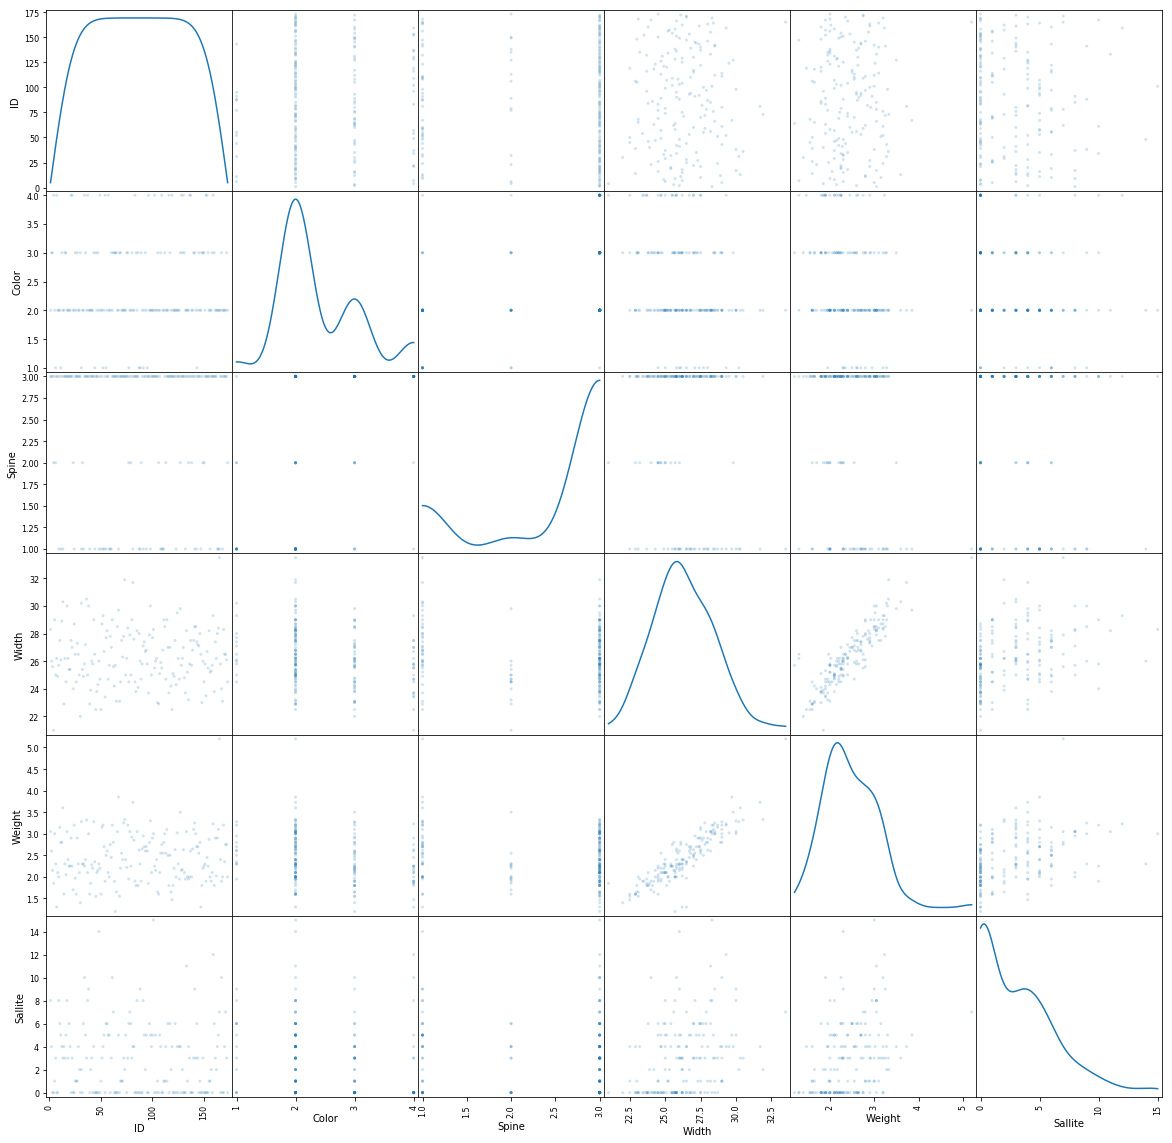

In [26]:
scatter_matrix(data, alpha=0.2, figsize=(20, 20), diagonal='kde')

### d) Schätzen Sie den Anteil des Rohöls im Test-Datensatz, das in Gasolin konvertiert wird, anhand anderer Indikatoren im Datensatz `gasoline.csv`.